<a href="https://colab.research.google.com/github/iabhaysharma/TREELEAF-ML-/blob/main/Bank_loan_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Train Test Split
from sklearn.model_selection import train_test_split

# Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold

# Validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from statistics import stdev

# Ensembling
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xg

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [46]:
from google.colab import files
uploaded = files.upload()

Saving New_Bank_loan_data.xlsx to New_Bank_loan_data (1).xlsx


In [47]:
import io
data = pd.read_excel('New_Bank_loan_data.xlsx')
df = pd.DataFrame(data)

# Dataset is now stored in a Pandas Dataframe

In [48]:
# View dimensions of dataset
rows, col = df.shape
print ("Dimensions of dataset: {}" . format (df.shape))
print ('Rows:', rows, '\nColumns:', col)

Dimensions of dataset: (5000, 16)
Rows: 5000 
Columns: 16


In [49]:
# Statistical details
df.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                          .style.background_gradient(cmap='PuBu')\
                          .bar(subset=["max"], color='#F8766D')\
                          .bar(subset=["mean",], color='#00BFC4')

,count,mean,std,min,25%,50%,75%,max
ZIP Code,5000.000000,93152.503000,2121.852197,9307.000000,91911.000000,93437.000000,94608.000000,96651.000000
ID,5000.000000,2500.500000,1443.520003,1.000000,1250.750000,2500.500000,3750.250000,5000.000000
Mortgage,5000.000000,56.498800,101.713802,0.000000,0.000000,0.000000,101.000000,635.000000
Income,4933.000000,72.758159,45.425519,8.000000,39.000000,63.000000,95.000000,224.000000
Age,5000.000000,46.008200,25.444898,0.000000,35.000000,45.000000,55.000000,978.000000
Experience,5000.000000,20.104600,11.467954,-3.000000,10.000000,20.000000,30.000000,43.000000
CCAvg,5000.000000,1.937913,1.747666,0.000000,0.700000,1.500000,2.500000,10.000000
Family,5000.000000,2.396400,1.147663,1.000000,1.000000,2.000000,3.000000,4.000000
Education,5000.000000,1.880600,0.839812,1.000000,1.000000,2.000000,3.000000,3.000000
Online,4960.000000,0.596976,0.490555,0.000000,0.000000,1.000000,1.000000,1.000000


In [50]:
# Number of uniqe elements in each columns
unique = df.nunique()
unique.to_frame().T

,ID,Age,Gender,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Home Ownership,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,5000,58,5,47,162,467,4,108,3,347,3,3,2,2,2,2


In [51]:
# Information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Gender              3404 non-null   object 
 3   Experience          5000 non-null   int64  
 4   Income              4933 non-null   float64
 5   ZIP Code            5000 non-null   int64  
 6   Family              5000 non-null   int64  
 7   CCAvg               5000 non-null   float64
 8   Education           5000 non-null   int64  
 9   Mortgage            5000 non-null   int64  
 10  Home Ownership      3811 non-null   object 
 11  Personal Loan       5000 non-null   object 
 12  Securities Account  5000 non-null   int64  
 13  CD Account          5000 non-null   int64  
 14  Online              4960 non-null   float64
 15  CreditCard          5000 non-null   int64  
dtypes: flo

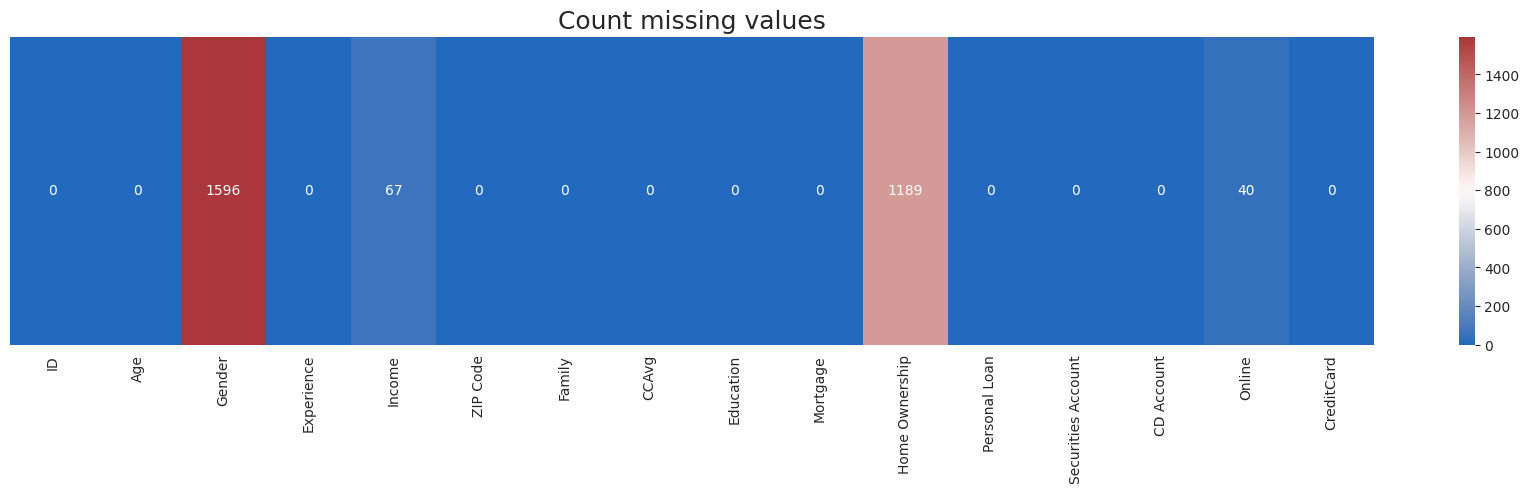

In [52]:
# Missing values
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='vlag',
            annot=True, fmt='0.0f').set_title('Count missing values', fontsize=18)
plt.show()

In [53]:
df.head(10).style.set_properties(**{'background-color': '#e3c8d2'}, subset=['CCAvg'])

,ID,Age,Gender,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Home Ownership,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,M,1,49.000000,91107,4,1.600000,1,0,Home Owner,0,1,0,0.000000,0
1,2,45,M,19,34.000000,90089,3,1.500000,1,0,Rent,0,1,0,0.000000,0
2,3,39,M,15,11.000000,94720,1,1.000000,1,0,Rent,0,0,0,0.000000,0
3,4,35,M,9,100.000000,94112,1,2.700000,2,0,Rent,0,0,0,0.000000,0
4,5,35,M,8,45.000000,91330,4,1.000000,2,0,Rent,0,0,0,0.000000,1
5,6,37,M,13,29.000000,92121,4,0.400000,2,155,Rent,0,0,0,1.000000,0
6,7,53,M,27,72.000000,91711,2,1.500000,2,0,Rent,0,0,0,1.000000,0
7,8,50,M,24,22.000000,93943,1,0.300000,3,0,Rent,0,0,0,0.000000,1
8,9,35,M,10,81.000000,90089,3,0.600000,2,104,Rent,0,0,0,1.000000,0
9,10,34,M,9,180.000000,93023,1,8.900000,3,0,Home Owner,1,0,0,0.000000,0


In [54]:
df['CCAvg'] = df['CCAvg'].astype('float64')
df.dtypes

ID                      int64
Age                     int64
Gender                 object
Experience              int64
Income                float64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Home Ownership         object
Personal Loan          object
Securities Account      int64
CD Account              int64
Online                float64
CreditCard              int64
dtype: object

In [55]:
neg = df.describe()
neg.style.set_properties(**{'background-color': '#e3c8d2'}, subset=['Experience'])

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,4933.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4960.000000,5000.000000
mean,2500.500000,46.008200,20.104600,72.758159,93152.503000,2.396400,1.937913,1.880600,56.498800,0.104400,0.060400,0.596976,0.294000
std,1443.520003,25.444898,11.467954,45.425519,2121.852197,1.147663,1.747666,0.839812,101.713802,0.305809,0.238250,0.490555,0.455637
min,1.000000,0.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,63.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,95.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,1.000000,1.000000
max,5000.000000,978.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.000000,1.000000


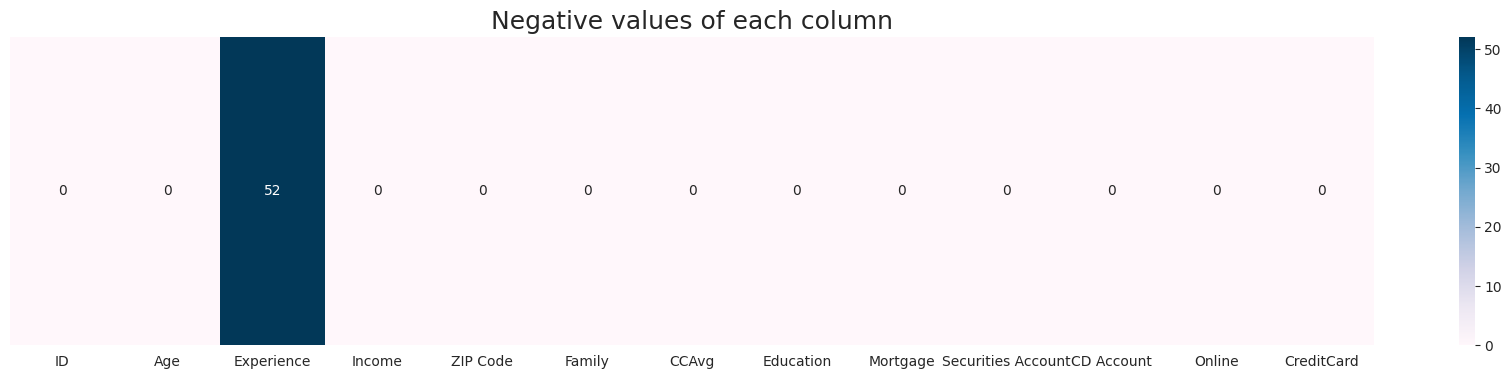

In [56]:
# Number of negative values of each feature
plt.figure(figsize=(22,4))
# Select only numeric columns before applying .lt(0)
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap((numeric_df.lt(0).sum()).to_frame(name='').T, cmap='PuBu', annot=True, fmt='0.0f').set_title('Negative values of each column', fontsize=18)
plt.show()

In [57]:
# Rows with negative Experience values
neg = df[df['Experience'] < 0 ]
neg.style.set_properties(**{'background-color': '#e3c8d2'}, subset=['Experience'])

,ID,Age,Gender,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Home Ownership,Personal Loan,Securities Account,CD Account,Online,CreditCard
89,90,25,M,-1,113.000000,94303,4,2.300000,3,0,Rent,0,0,0,0.000000,1
226,227,24,nan,-1,39.000000,94085,2,1.700000,2,0,Home Mortage,0,0,0,0.000000,0
315,316,24,M,-2,51.000000,90630,3,0.300000,3,0,Rent,0,0,0,1.000000,0
451,452,28,M,-2,48.000000,94132,2,1.750000,1,89,Home Mortage,0,0,0,1.000000,0
524,525,24,M,-1,75.000000,93014,4,0.200000,1,0,Home Owner,0,0,0,1.000000,0
536,537,25,F,-1,43.000000,92173,3,2.400000,2,176,nan,0,0,0,1.000000,0
540,541,25,F,-1,109.000000,94010,4,2.300000,3,314,Home Owner,0,0,0,1.000000,0
576,577,25,M,-1,48.000000,92870,3,0.300000,3,0,Home Owner,0,0,0,0.000000,1
583,584,24,M,-1,38.000000,95045,2,1.700000,2,0,Home Owner,0,0,0,1.000000,0
597,598,24,F,-2,125.000000,92835,2,7.200000,1,0,Rent,0,1,0,0.000000,1


In [58]:
df['Experience']= abs(df['Experience'])

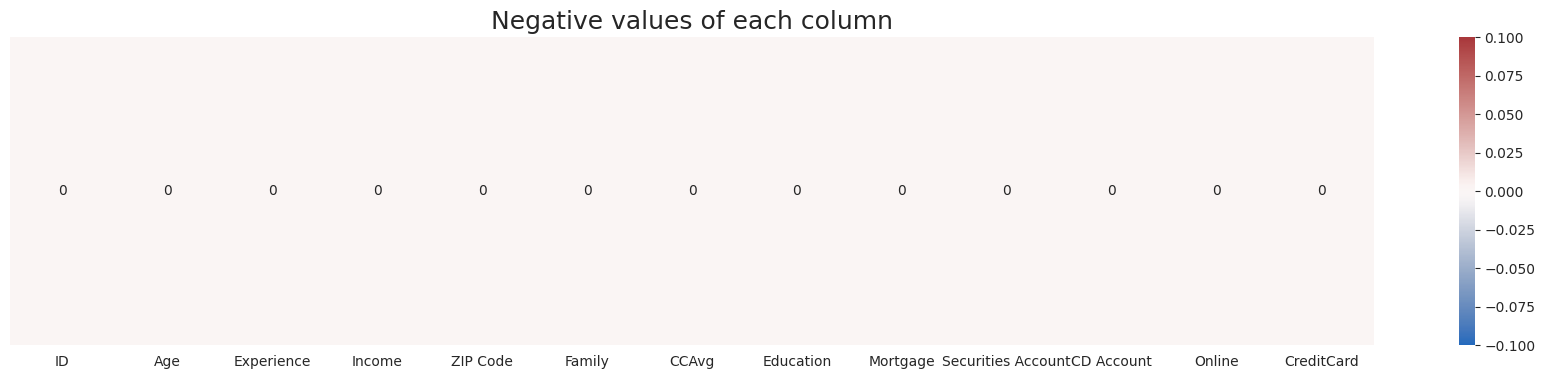

In [59]:
# Check for negative values
plt.figure(figsize=(22,4))
# Select only numeric columns before applying .lt(0)
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap((numeric_df.lt(0).sum()).to_frame(name='').T, cmap='vlag',
            annot=True, fmt='0.0f').set_title('Negative values of each column', fontsize=18)
plt.show()

In [60]:
# Duplicated data
df.duplicated().sum()

0

In [61]:
#CCAvg is based on month, while Income is based on year.
#So, we decide to convert income monthly.
df['Income'] = round(df['Income']/12, 2)
df.head(10).style.set_properties(**{'background-color': '#e3c8d2'}, subset=['Income'])

,ID,Age,Gender,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Home Ownership,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,M,1,4.080000,91107,4,1.600000,1,0,Home Owner,0,1,0,0.000000,0
1,2,45,M,19,2.830000,90089,3,1.500000,1,0,Rent,0,1,0,0.000000,0
2,3,39,M,15,0.920000,94720,1,1.000000,1,0,Rent,0,0,0,0.000000,0
3,4,35,M,9,8.330000,94112,1,2.700000,2,0,Rent,0,0,0,0.000000,0
4,5,35,M,8,3.750000,91330,4,1.000000,2,0,Rent,0,0,0,0.000000,1
5,6,37,M,13,2.420000,92121,4,0.400000,2,155,Rent,0,0,0,1.000000,0
6,7,53,M,27,6.000000,91711,2,1.500000,2,0,Rent,0,0,0,1.000000,0
7,8,50,M,24,1.830000,93943,1,0.300000,3,0,Rent,0,0,0,0.000000,1
8,9,35,M,10,6.750000,90089,3,0.600000,2,104,Rent,0,0,0,1.000000,0
9,10,34,M,9,15.000000,93023,1,8.900000,3,0,Home Owner,1,0,0,0.000000,0


In [71]:
# Drop columns, ignoring errors if they don't exist
df.drop(['ID','Gender', 'ZIP Code','Home Ownership'], axis=1, inplace=True, errors='ignore')
df.shape

(5000, 12)

In [72]:
# Separate numerical features
num_cols = pd.DataFrame (df, columns= ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage'])
cat_cols = pd.DataFrame (df, columns= ['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard'])

In [73]:
# Separate numerical and categorical features into different lists first
numerical_columns = list(df.loc[:,['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']])
categorical_columns = list(df.loc[:,['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']])

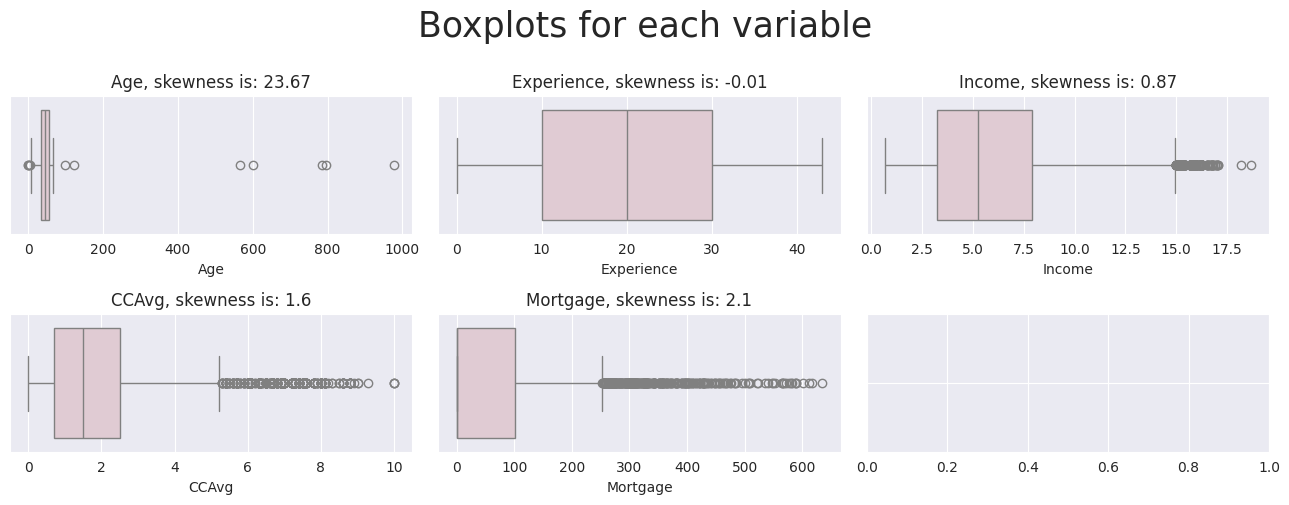

In [74]:
# Visualizing the Numerical Features by boxplots
sns.set_style('darkgrid')
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', color ='#e3c8d2', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(dataset=df, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

In [75]:
# Calculate the IQR for each column in the dataset
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using the IQR method
outliers = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR)))

# Count the number of outliers for each variable
num_outliers = outliers.sum()

# Number of outliers for each variable
num_outliers.to_frame().T

,Age,Experience,Income,CCAvg,Mortgage
0,11,0,158,324,291


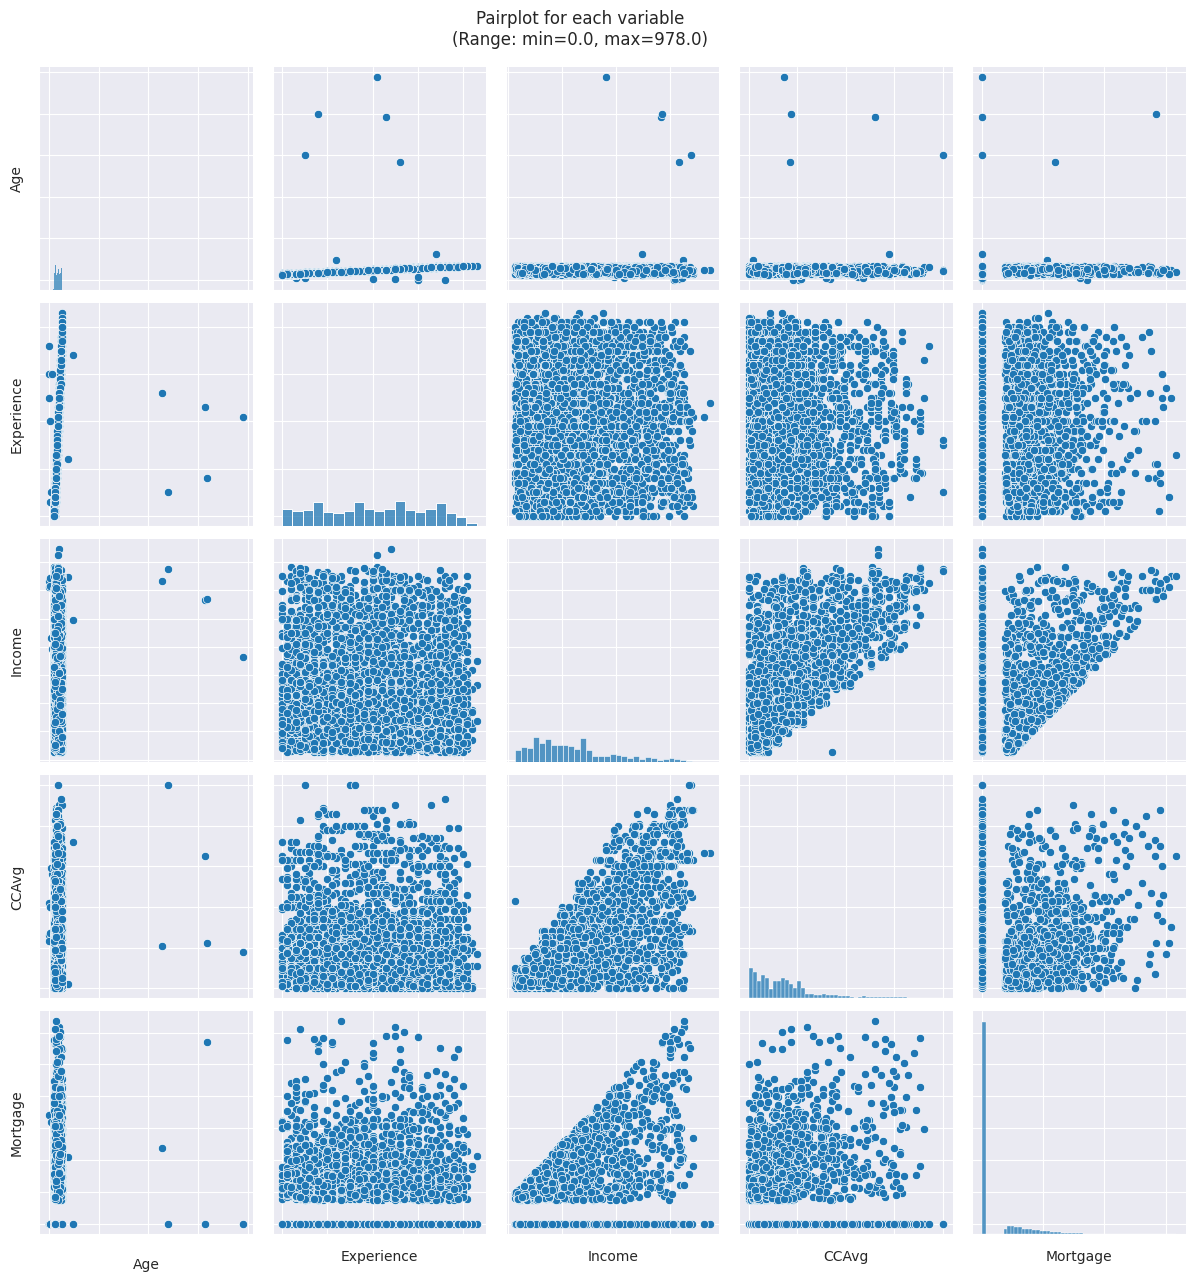

In [77]:
#check for noises
sns.set_style('darkgrid')
dnp = sns.pairplot(df.loc[:, numerical_columns], palette=['PuBu'])

# Add axis labels and tick labels to the plot
dnp.set(xticklabels=[], yticklabels=[])
dnp.axes[0][0].set_ylabel(numerical_columns[0], fontsize=10)
dnp.axes[-1][0].set_xlabel(numerical_columns[0], fontsize=10)
dnp.axes[-1][0].xaxis.labelpad = 10
dnp.axes[-1][-1].yaxis.labelpad = 10

# Title of the plot
dnp.fig.suptitle('Pairplot for each variable\n(Range: min={}, max={})'.format(df[numerical_columns].min().min(), df[numerical_columns].max().max()), y=1.03, fontsize=12)

# Show the plot
plt.show()


In [78]:
# Final dataset after cleaning
df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,4.08,4,1.6,1,0,0,1,0,0.0,0
1,45,19,2.83,3,1.5,1,0,0,1,0,0.0,0
2,39,15,0.92,1,1.0,1,0,0,0,0,0.0,0
3,35,9,8.33,1,2.7,2,0,0,0,0,0.0,0
4,35,8,3.75,4,1.0,2,0,0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,3.33,1,1.9,3,0,0,0,0,1.0,0
4996,30,4,1.25,4,0.4,1,85,0,0,0,1.0,0
4997,63,39,2.00,2,0.3,3,0,0,0,0,0.0,0
4998,65,40,4.08,3,0.5,2,0,0,0,0,1.0,0


Total number of features except for the target: 11
Number of categorical (<25 Unique Values) features: 6
Number of continuous features: 5


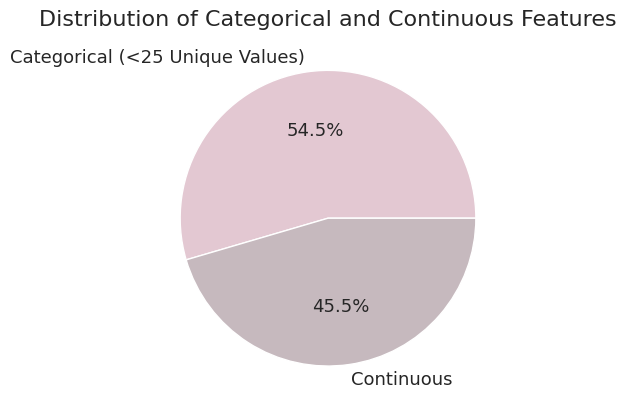

In [79]:
TARGET = 'Personal Loan'
FEATURES = [col for col in df.columns if col not in ['df', TARGET]]

cat_features = [col for col in FEATURES if df[col].nunique() < 25]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25]

num_cat_features = len(cat_features)
num_cont_features = len(cont_features)

print(f"Total number of features except for the target: {len(FEATURES)}")
print(f"\033[92mNumber of categorical (<25 Unique Values) features: {num_cat_features}")
print(f"\033[96mNumber of continuous features: {num_cont_features}")

# Define labels and colors for the pie chart
labels = ['Categorical (<25 Unique Values)', 'Continuous']
colors = ['#e3c8d2', '#c6b9be']

plt.pie([num_cat_features, num_cont_features],
        labels=labels,
        colors=colors,
        textprops={'fontsize': 13},
        autopct='%1.1f%%')

# Add a title to the plot
plt.title('Distribution of Categorical and Continuous Features', fontsize=16)

# Show the plot
plt.show()

In [80]:
y = df['Personal Loan']
print(f'Percentage of Borrowed loan:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} Customer)\nPercentage of Unborrowed loan: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} Customer)')


Percentage of Borrowed loan:  9.58 %  --> (479 Customer)
Percentage of Unborrowed loan: 90.4  %  --> (4520 Customer)


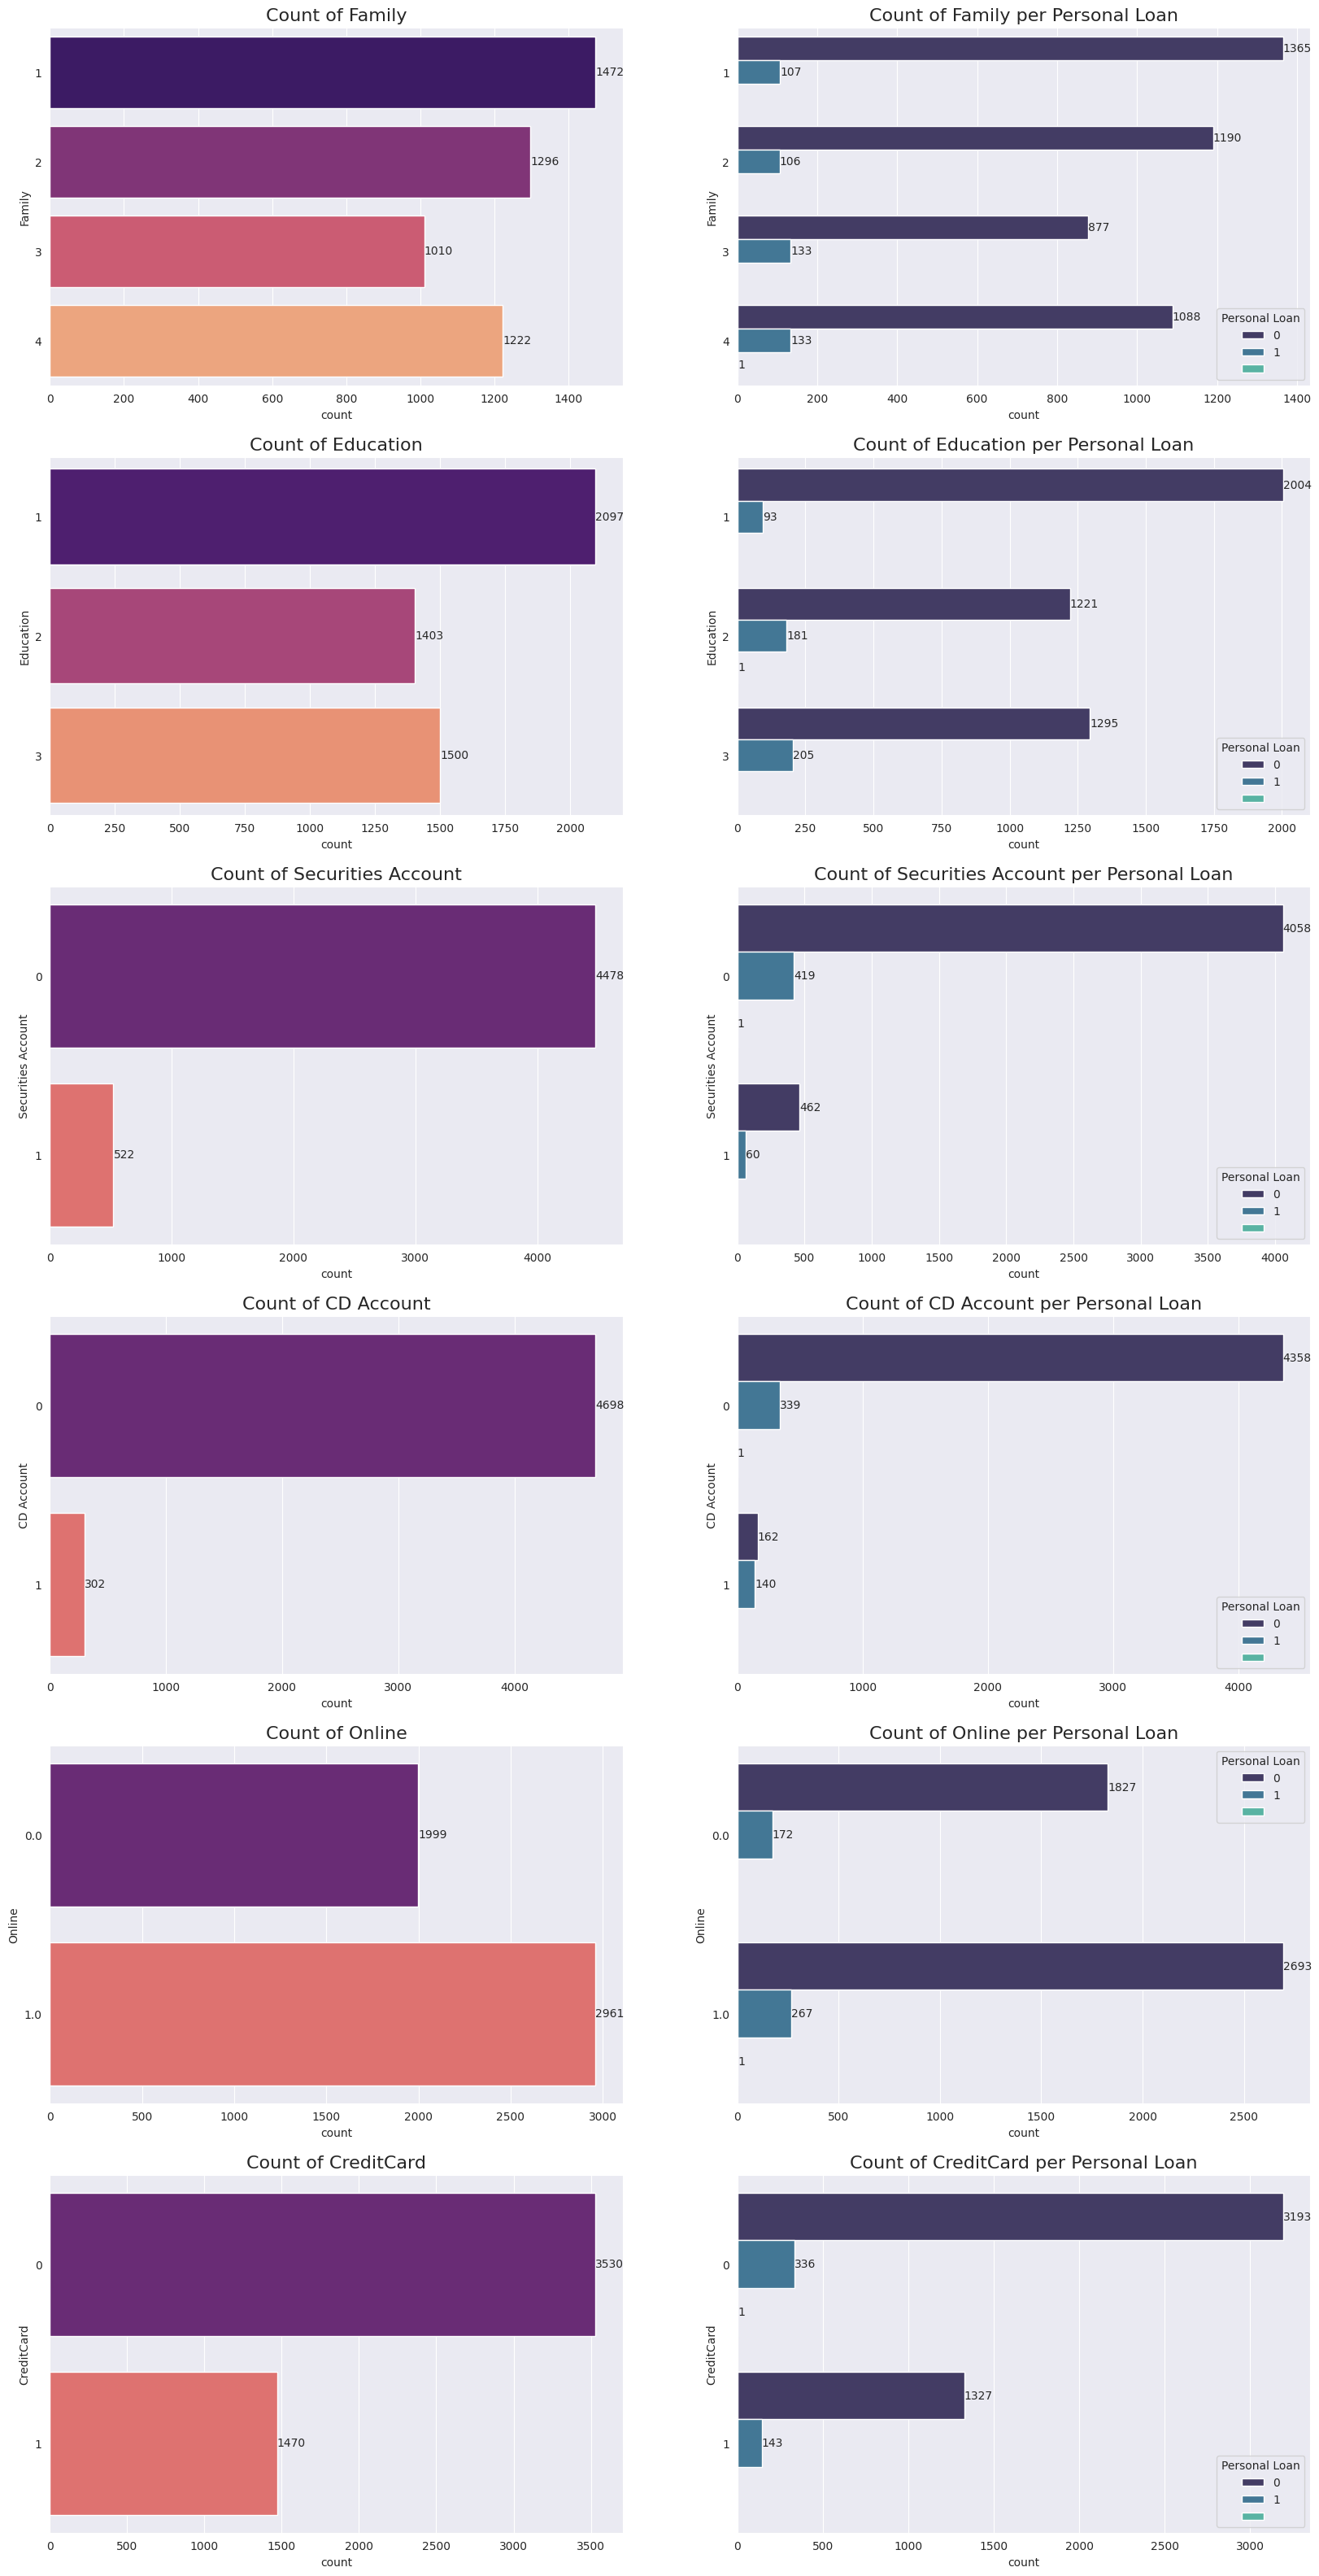

In [86]:
#Exploring Categorical Features
fig, axes = plt.subplots(6,2, figsize=(20,40))
sns.set_style('darkgrid')
idx = 0
for col in categorical_columns:
    sns.countplot(data=df, y=col, palette='magma', orient='h',
                  ax=axes[idx][0]).set_title(f'Count of {col}', fontsize='16')
    for container in axes[idx][0].containers:
        axes[idx][0].bar_label(container)
    sns.countplot(data=df, y=col, palette='mako', orient='h',  hue='Personal Loan',
                  ax=axes[idx][1]).set_title(f'Count of {col} per Personal Loan', fontsize='16')
    for container in axes[idx][1].containers:
        axes[idx][1].bar_label(container)
    idx +=1
plt.show()

In [87]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' +
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>')

In [88]:
print("An overview of percentages of each unique value in different categorical features:")
df_nunique = {var: pd.DataFrame((df[var].value_counts()/len(df[var])*100).map('{:.2f}%'.format))
              for var in {'Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard'}}
multi_table([df_nunique['Family'], df_nunique['Education'],df_nunique['Securities Account'],df_nunique['CD Account'],df_nunique['Online'],df_nunique['CreditCard']])

An overview of percentages of each unique value in different categorical features:


,count
Family,
1,29.44%
2,25.92%
4,24.44%
3,20.20%
,count
Education,
1,41.94%
3,30.00%
2,28.06%


In [89]:
# Describing the categorical variables
cat_cols.describe().style.background_gradient(cmap='PuBu')

,Family,Education,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,4960.000000,5000.000000
mean,2.396400,1.880600,0.104400,0.060400,0.596976,0.294000
std,1.147663,0.839812,0.305809,0.238250,0.490555,0.455637
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000
max,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000


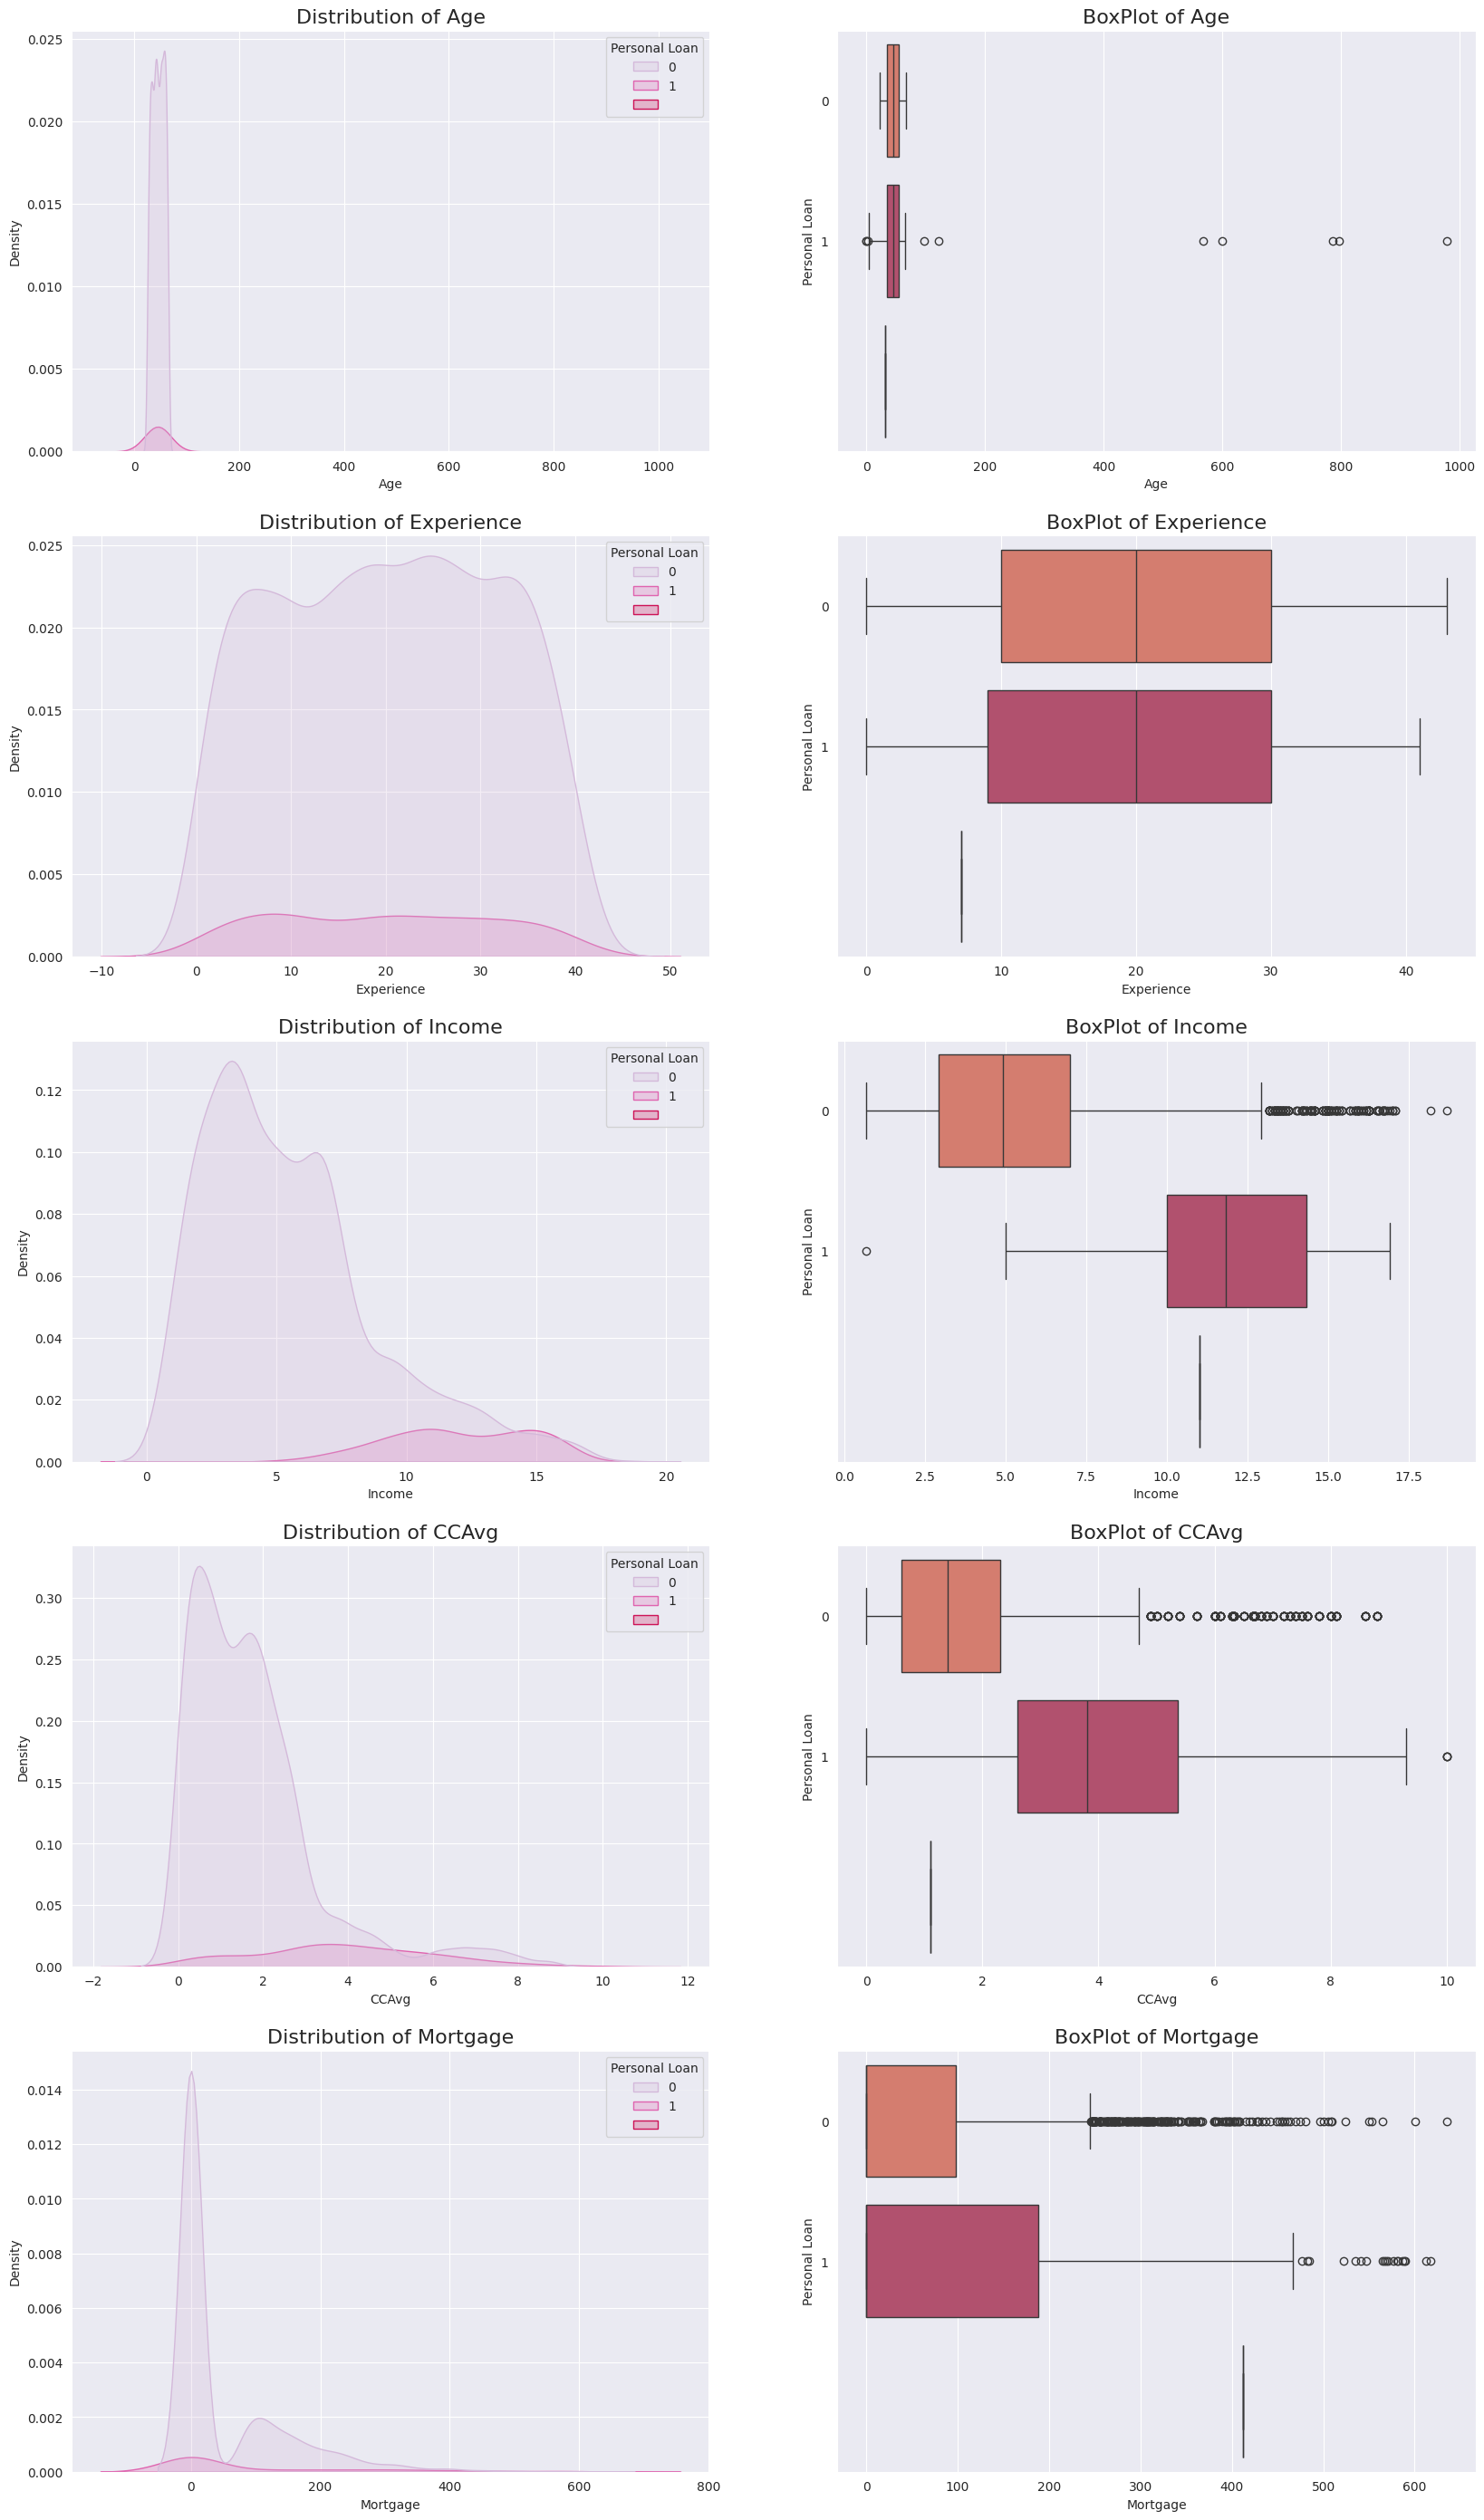

In [90]:
#Exploring Numerical Features
fig, axes = plt.subplots(5,2, figsize=(20,35))
sns.set_style('darkgrid')
idx = 0
for col in (numerical_columns):
    sns.kdeplot(data=df, x=col, palette='PuRd',fill=True , hue='Personal Loan',
                ax=axes[idx][0]).set_title(f'Distribution of {col}', fontsize='16')
    sns.boxplot(data=df, x=col, palette='flare' , y='Personal Loan', orient='h',
                ax=axes[idx][1]).set_title(f'BoxPlot of {col}', fontsize='16')
    idx +=1
plt.show()

In [91]:
# The average values of borrowing and not borrowing in different variables
df.groupby(df['Personal Loan']).mean().T.style.background_gradient(cmap='PuBu')

Personal Loan,0,1,
Age,45.367257,52.085595,32.000000
Experience,20.165487,19.870564,7.000000
Income,5.519827,12.012937,11.000000
Family,2.373451,2.609603,4.000000
CCAvg,1.728982,3.911204,1.100000
Education,1.843142,2.233820,2.000000
Mortgage,51.789381,100.196242,412.000000
Securities Account,0.102212,0.125261,0.000000
CD Account,0.035841,0.292276,0.000000
Online,0.595796,0.608200,1.000000


In [92]:
#bivarient analysis
df.Age.describe()

count    5000.000000
mean       46.008200
std        25.444898
min         0.000000
25%        35.000000
50%        45.000000
75%        55.000000
max       978.000000
Name: Age, dtype: float64

In [93]:
print('Oldest:',df['Age'].max(),'Years old')
print('Youngest:',df['Age'].min(),'Years old')
print('Average Age:',df['Age'].mean(),'Years old')

Oldest: 978 Years old
Youngest: 0 Years old
Average Age: 46.0082 Years old


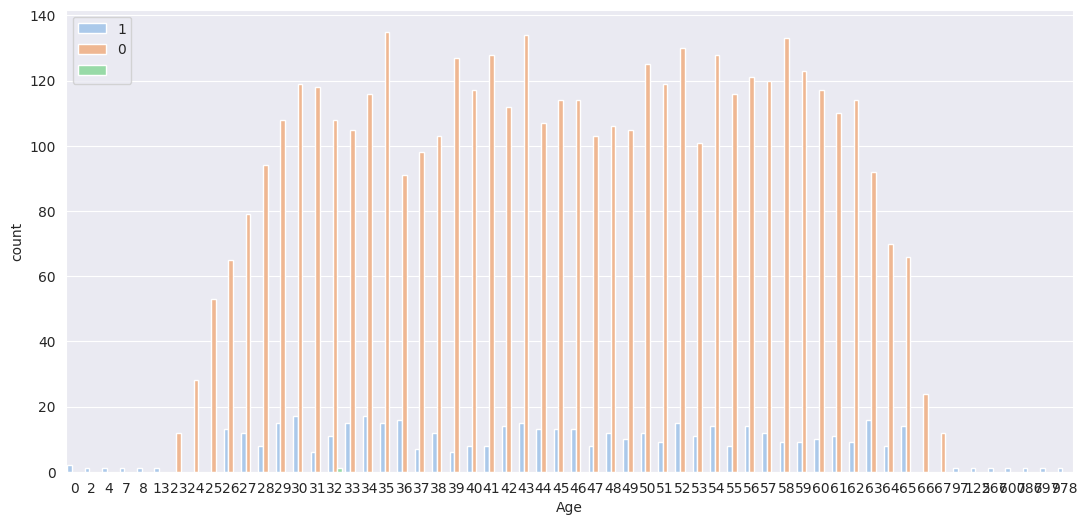

In [94]:
# Age based on Personal Loan
plt.figure(figsize = (13,6))
sns.countplot(x = df['Age'], hue ="Personal Loan", data=df, palette="pastel")
plt.legend(loc='upper left')
plt.show()

In [95]:
df.Experience.describe()

count    5000.000000
mean       20.134600
std        11.415189
min         0.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: Experience, dtype: float64

In [96]:
print('Max:',df['Experience'].max(),'Years Experience')
print('Min:',df['Experience'].min(),'Years Experience')
print('Mean:',df['Experience'].mean(),'Years Experience')

Max: 43 Years Experience
Min: 0 Years Experience
Mean: 20.1346 Years Experience


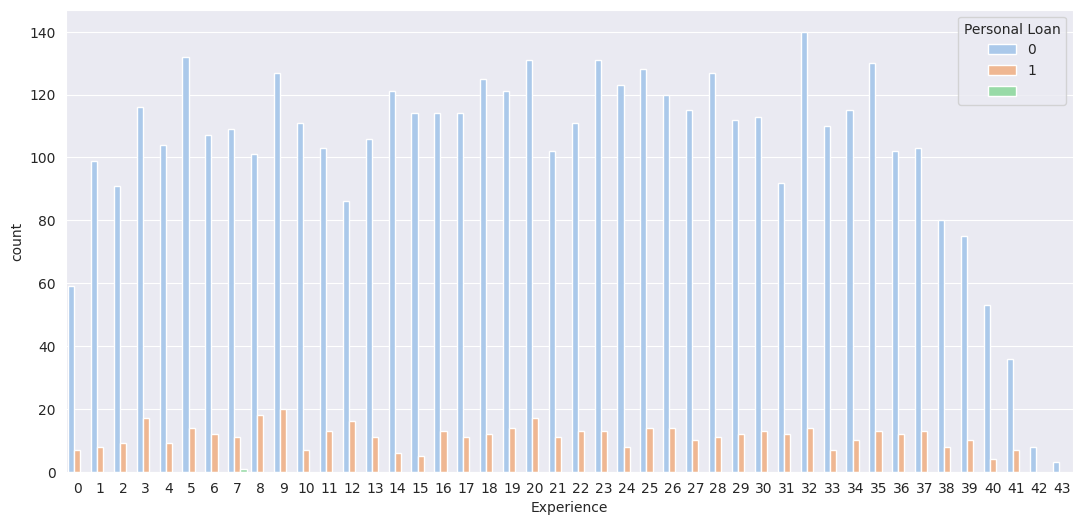

In [97]:
# Experience based on Personal Loan
plt.figure(figsize = (13,6))
sns.countplot(x = df['Experience'], hue ="Personal Loan", data=df, palette="pastel")
plt.show()

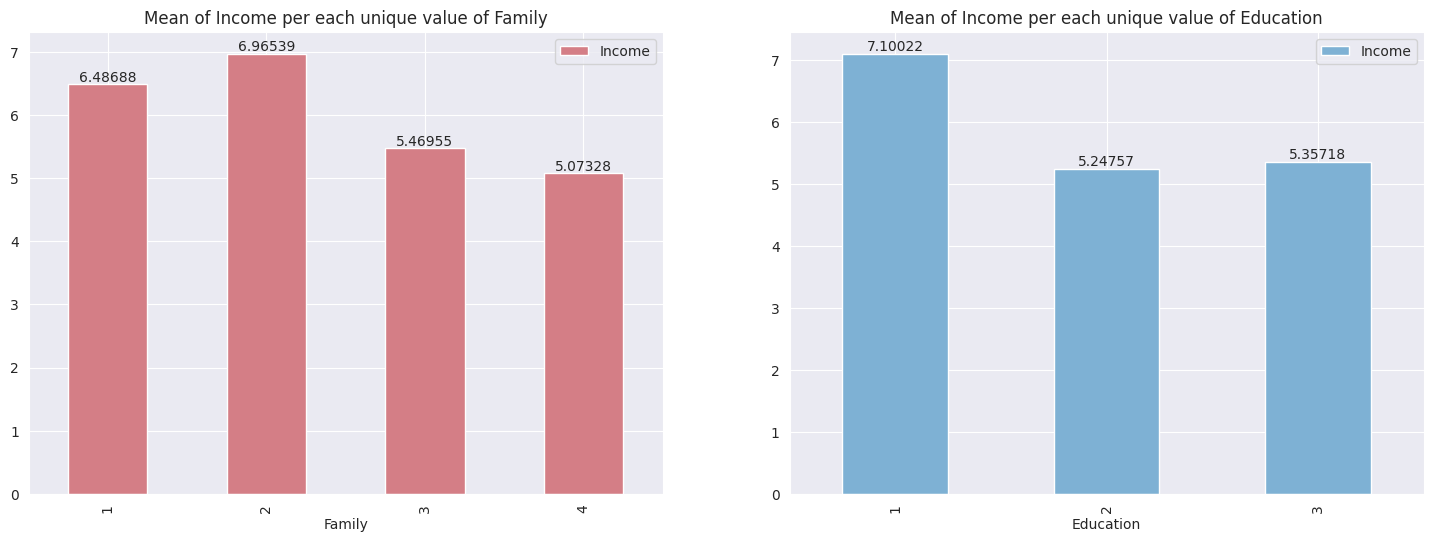

In [98]:
#Mean of 'Income' per each unique value of different categorical features:
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['Income','Family']].groupby(['Family']).mean().plot.bar(color='#d47e86',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of Income per each unique value of Family')

ax2= df[['Income','Education']].groupby(['Education']).mean().plot.bar(color='#7eb1d4',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of Income per each unique value of Education')

plt.show()

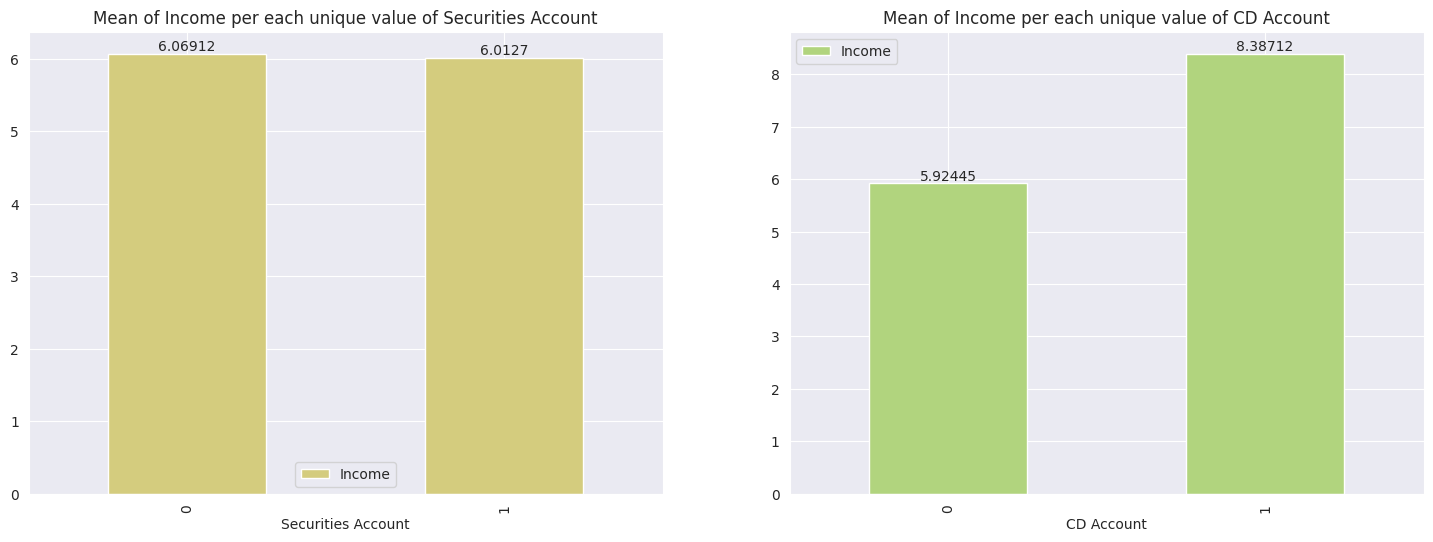

In [99]:
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['Income','Securities Account']].groupby(['Securities Account']).mean().plot.bar(color='#d4cc7e',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of Income per each unique value of Securities Account')

ax2= df[['Income','CD Account']].groupby(['CD Account']).mean().plot.bar(color='#b1d47e',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of Income per each unique value of CD Account')

plt.show()

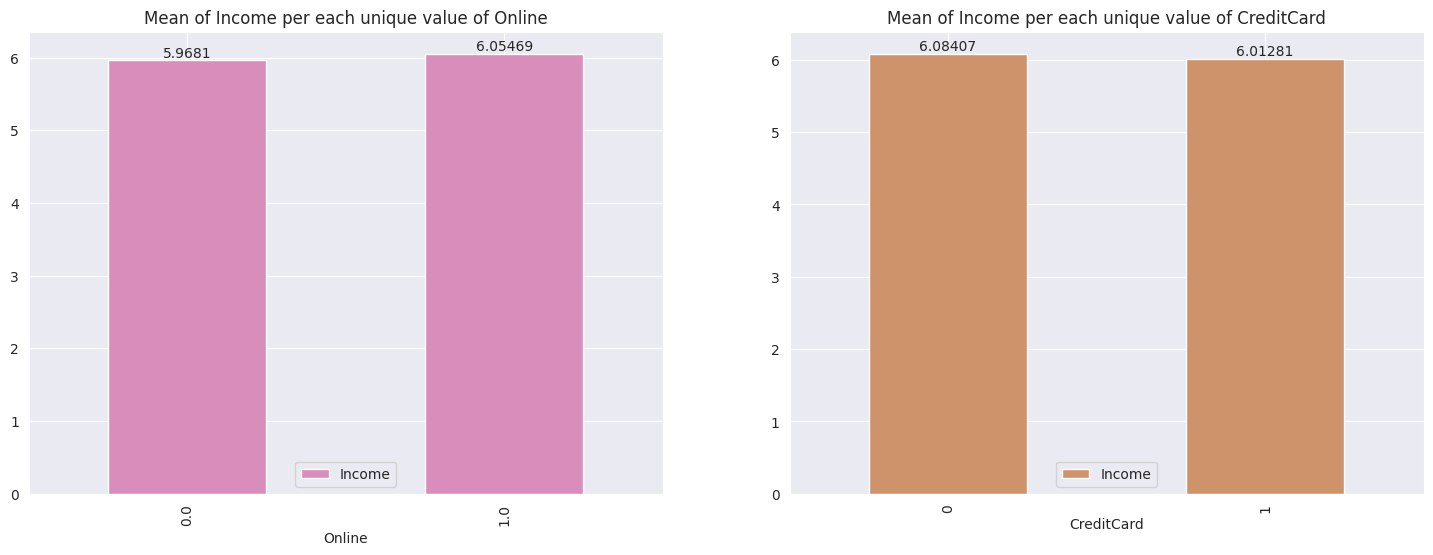

In [100]:
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['Income','Online']].groupby(['Online']).mean().plot.bar(color='#d98dba',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of Income per each unique value of Online')

ax2= df[['Income','CreditCard']].groupby(['CreditCard']).mean().plot.bar(color='#ce936b',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of Income per each unique value of CreditCard')

plt.show()

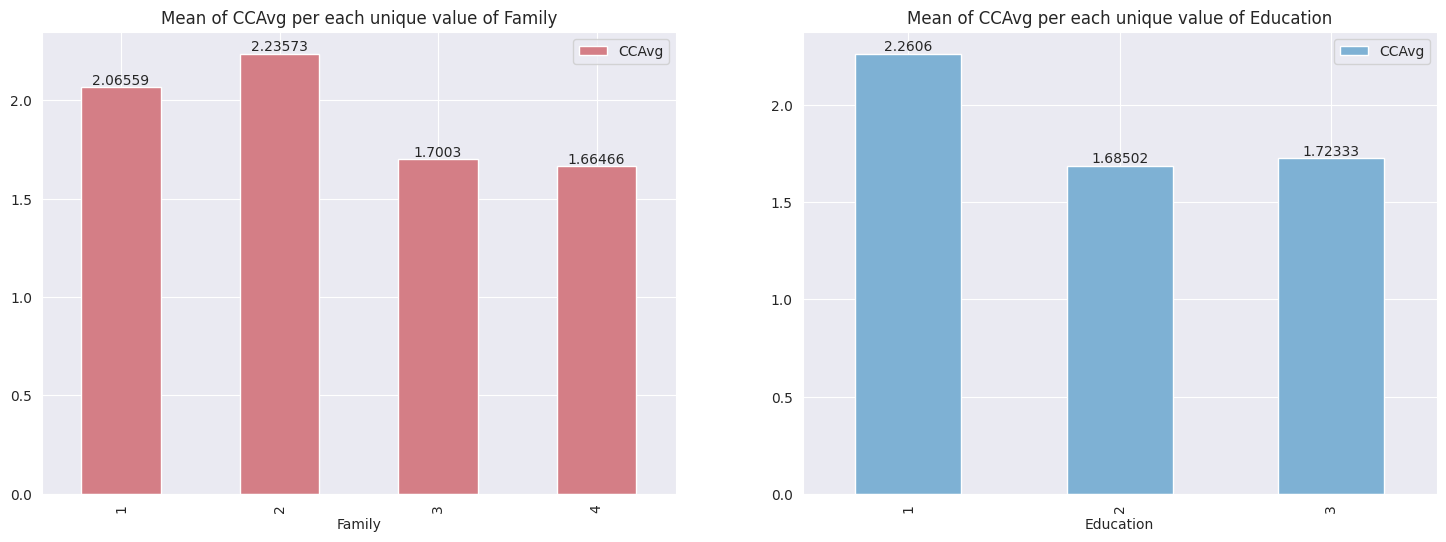

In [101]:
#Mean of 'CCAvg' per each unique value of different categorical features
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['CCAvg','Family']].groupby(['Family']).mean().plot.bar(color='#d47e86',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of CCAvg per each unique value of Family')

ax2= df[['CCAvg','Education']].groupby(['Education']).mean().plot.bar(color='#7eb1d4',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of CCAvg per each unique value of Education')

plt.show()

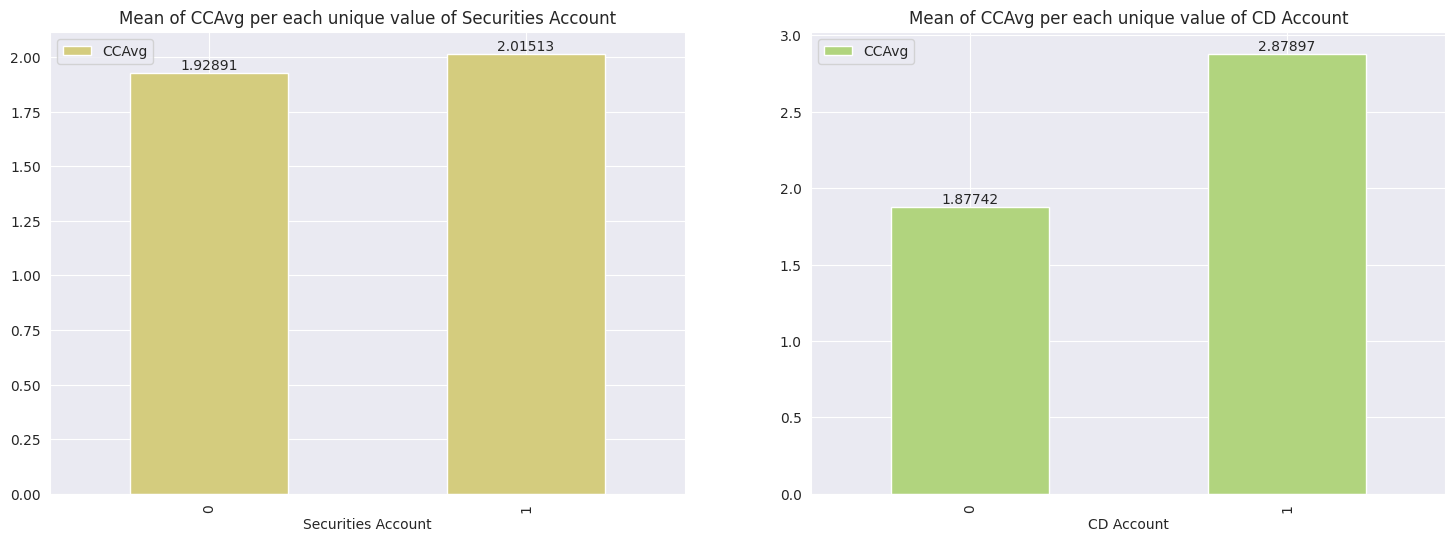

In [102]:
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['CCAvg','Securities Account']].groupby(['Securities Account']).mean().plot.bar(color='#d4cc7e',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of CCAvg per each unique value of Securities Account')

ax2= df[['CCAvg','CD Account']].groupby(['CD Account']).mean().plot.bar(color='#b1d47e',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of CCAvg per each unique value of CD Account')

plt.show()

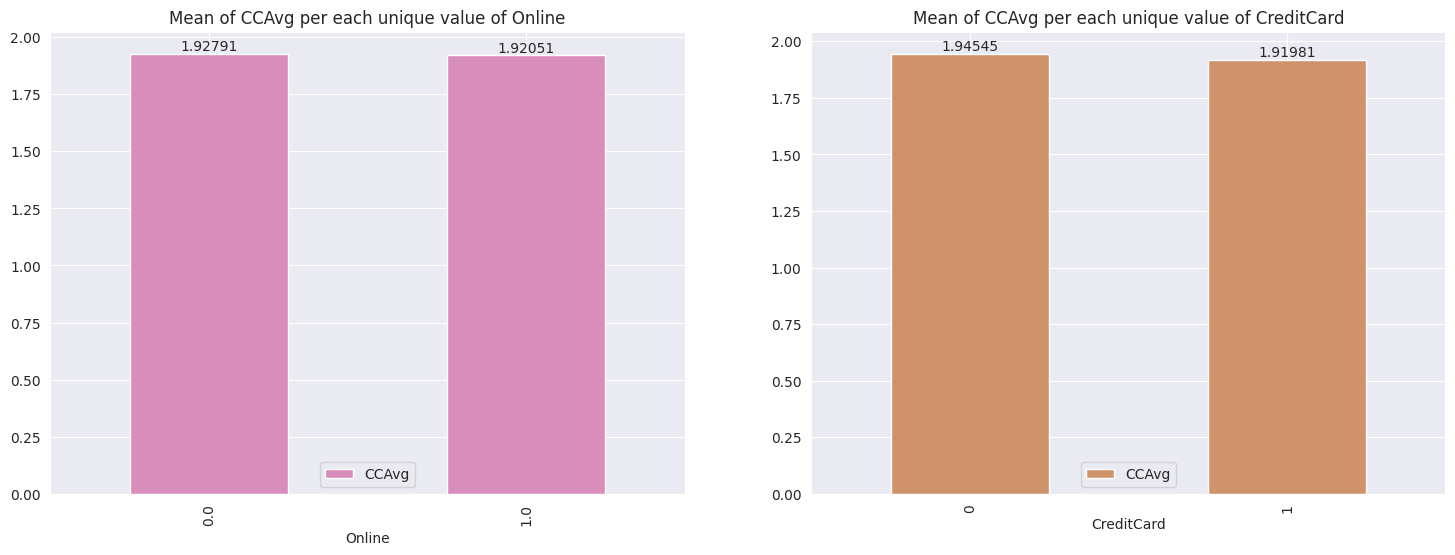

In [103]:
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['CCAvg','Online']].groupby(['Online']).mean().plot.bar(color='#d98dba',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of CCAvg per each unique value of Online')

ax2= df[['CCAvg','CreditCard']].groupby(['CreditCard']).mean().plot.bar(color='#ce936b',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of CCAvg per each unique value of CreditCard')

plt.show()

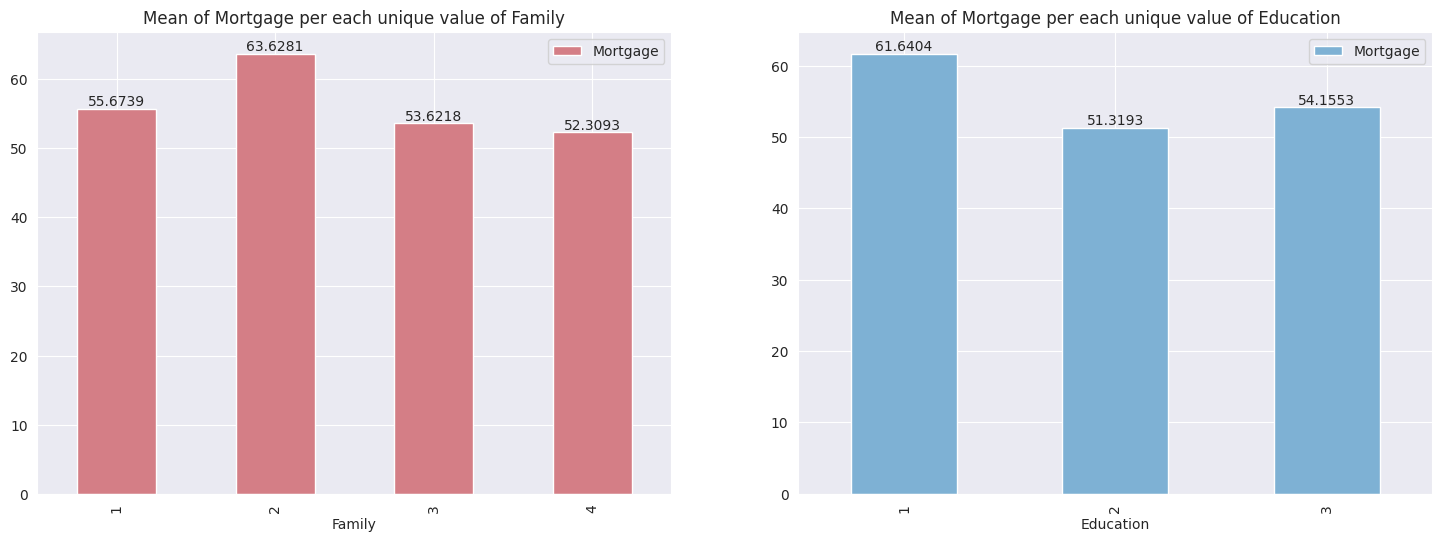

In [104]:
#Mean of 'Mortgage' per each unique value of different categorical features
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['Mortgage','Family']].groupby(['Family']).mean().plot.bar(color='#d47e86',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of Mortgage per each unique value of Family')

ax2= df[['Mortgage','Education']].groupby(['Education']).mean().plot.bar(color='#7eb1d4',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of Mortgage per each unique value of Education')

plt.show()

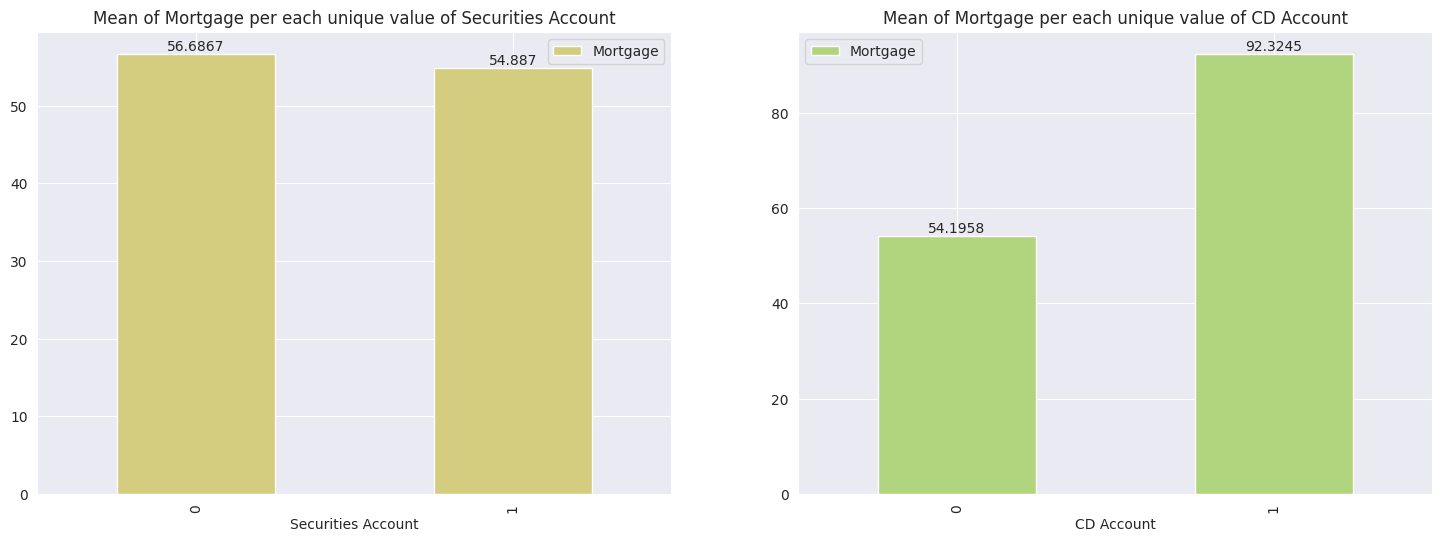

In [105]:
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['Mortgage','Securities Account']].groupby(['Securities Account']).mean().plot.bar(color='#d4cc7e',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of Mortgage per each unique value of Securities Account')

ax2= df[['Mortgage','CD Account']].groupby(['CD Account']).mean().plot.bar(color='#b1d47e',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of Mortgage per each unique value of CD Account')

plt.show()

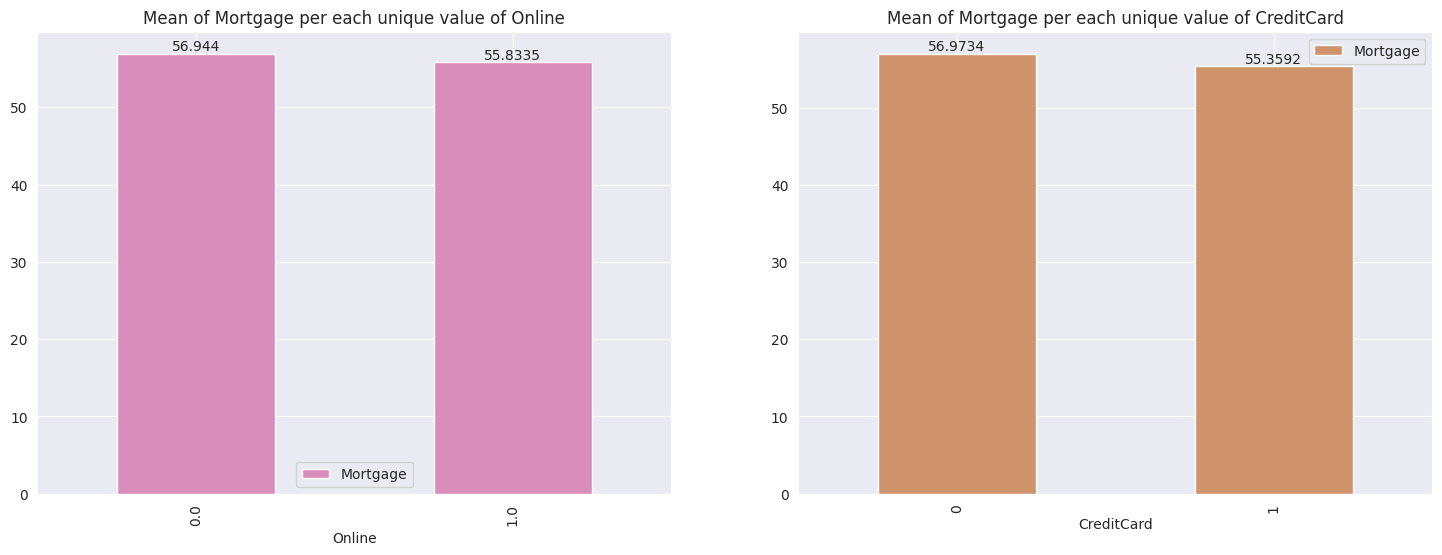

In [106]:
f,ax=plt.subplots(1,2,figsize=(18,6))

ax1= df[['Mortgage','Online']].groupby(['Online']).mean().plot.bar(color='#d98dba',ax=ax[0])
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title('Mean of Mortgage per each unique value of Online')

ax2= df[['Mortgage','CreditCard']].groupby(['CreditCard']).mean().plot.bar(color='#ce936b',ax=ax[1])
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title('Mean of Mortgage per each unique value of CreditCard')

plt.show()

In [107]:
df.loc[:, ~df.columns.isin(categorical_columns)].describe().T.style.background_gradient(cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
Age,5000.000000,46.008200,25.444898,0.000000,35.000000,45.000000,55.000000,978.000000
Experience,5000.000000,20.134600,11.415189,0.000000,10.000000,20.000000,30.000000,43.000000
Income,4933.000000,6.063237,3.785536,0.670000,3.250000,5.250000,7.920000,18.670000
CCAvg,5000.000000,1.937913,1.747666,0.000000,0.700000,1.500000,2.500000,10.000000
Mortgage,5000.000000,56.498800,101.713802,0.000000,0.000000,0.000000,101.000000,635.000000


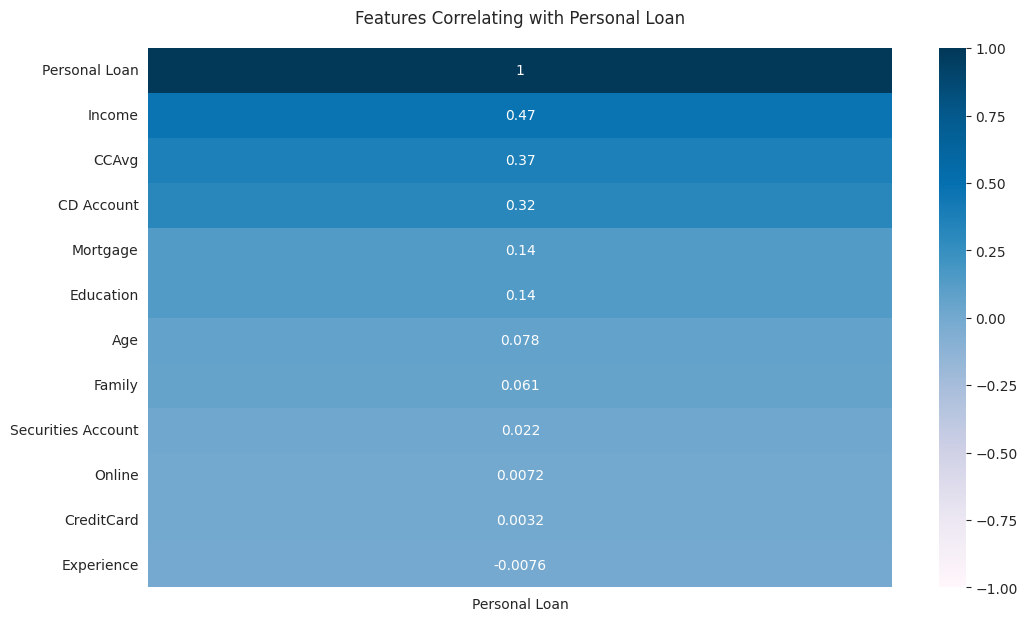

In [109]:
#Handle non-numerical values before calculating correlation
df_numeric = df.apply(pd.to_numeric, errors='coerce') # Convert to numeric, replacing non-convertible values with NaN

#Multivarient analysis
plt.figure (figsize = (12, 7), dpi = 100)
heatmap = sns.heatmap (df_numeric.corr()[['Personal Loan']].sort_values (by = 'Personal Loan', ascending = False), vmin = -1, vmax = 1, annot = True, cmap = 'PuBu')
heatmap.set_title ('Features Correlating with Personal Loan', fontdict = {'fontsize':12}, pad = 18);

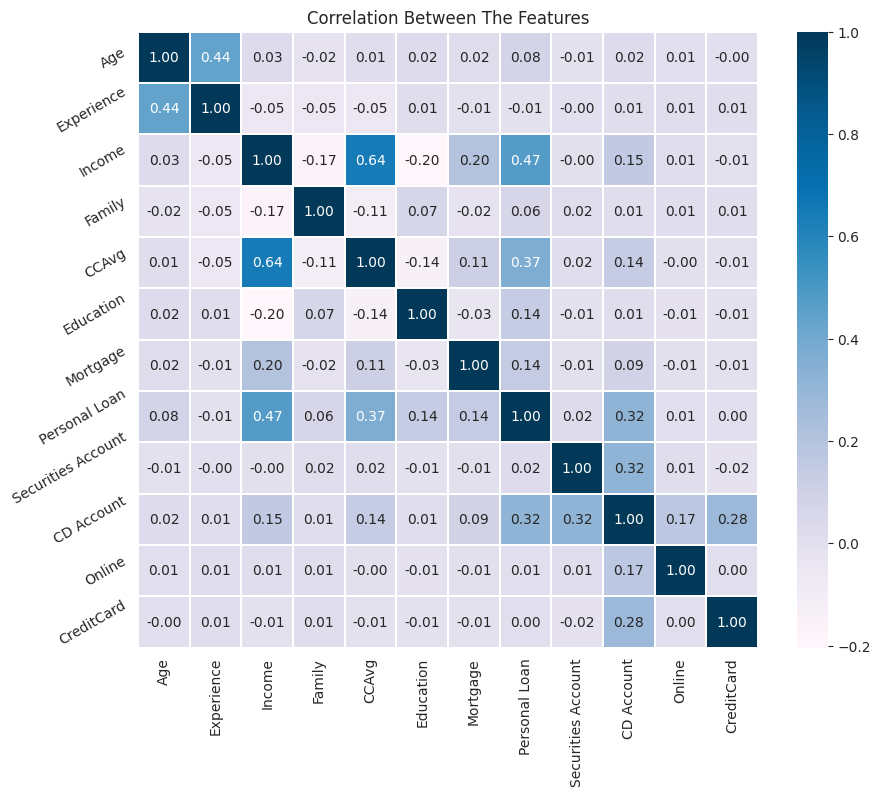

In [111]:
#Handle non-numerical values before calculating correlation
df_numeric = df.apply(pd.to_numeric, errors='coerce') # Convert to numeric, replacing non-convertible values with NaN

#Correlation Between The Features
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Correlation Between The Features')
a = sns.heatmap(df_numeric.corr(), annot=True, cmap='PuBu', fmt='.2f', linewidths=0.2) #Use the numeric DataFrame here
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()

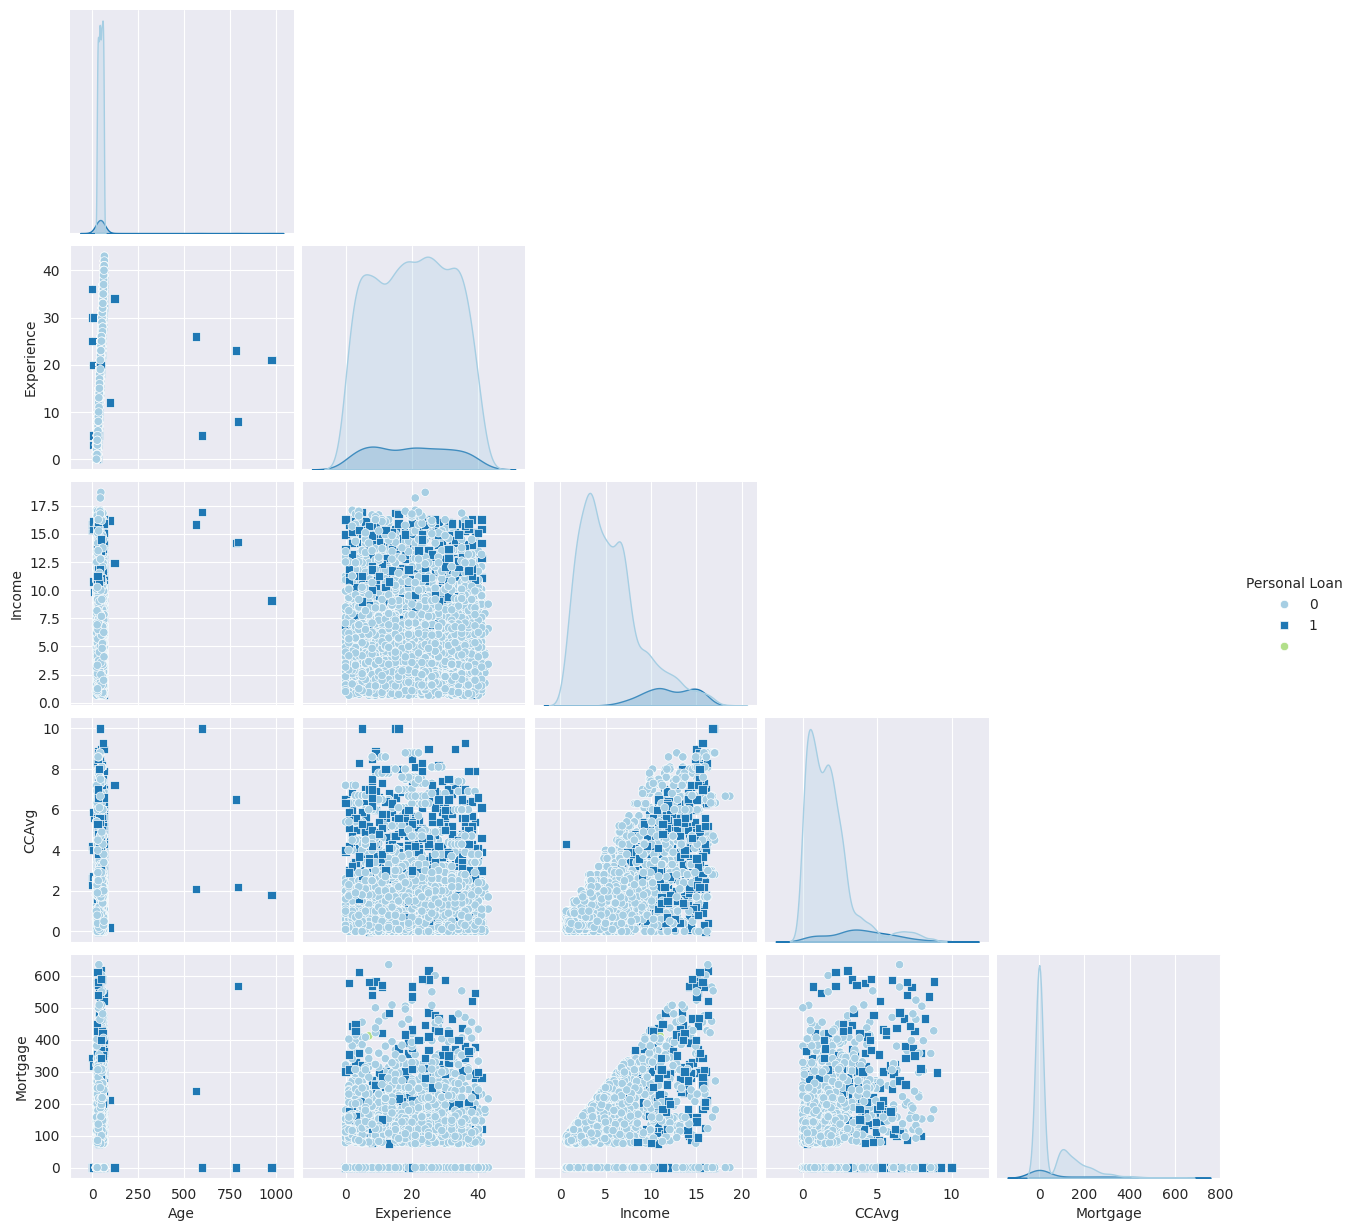

In [112]:
# Pairplot based on Personal Loan
sns.set_palette(sns.color_palette("Paired", 8))
sns.pairplot(df, x_vars=['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage'],
                 y_vars=['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage'],
                 hue='Personal Loan', markers=["o", "s"], corner=True)
plt.show()

In [126]:
#modelbulding
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'].ravel()

# Convert y to numeric, handling errors
y = pd.to_numeric(y, errors='coerce')

# Remove any rows with missing values in the target variable
X = X.loc[~np.isnan(y)]
y = y[~np.isnan(y)]

# Check the shape of X and y
print ('X:', X.shape, '\ny:', y.shape)


# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace missing values with the mean of each column
X_imputed = imputer.fit_transform(X)

# Array of test size value from 0.2 to 0.3
test_size = np.arange(start=0.2, stop=0.35, step= 0.05)

# Initialize a list where we'll store the score of each test size
score =[]
for size in test_size:
    X_train1, X_test1, y_train1, y_test1 = train_test_split (X_imputed, y, test_size=size, random_state=0) # Use the imputed data here
    log_model = LogisticRegression (solver="newton-cg", C=1, n_jobs=-1, random_state=0)
    log_model.fit (X_train1, y_train1)
    score.append (log_model.score (X_test1, y_test1))

r= pd.DataFrame({'Test size': test_size, 'Score': score})
r.sort_values(by = ['Score'], ascending = False, inplace = True)
r.style.highlight_max(color='#acd9a8')

X: (4999, 11) 
y: (4999,)


,Test size,Score
2,0.300000,0.937333
1,0.250000,0.936000
0,0.200000,0.935000


In [127]:
# Split X and y into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 0)

In [128]:
# check the shape of X_train, X_test, y_train and y_test
print('X_train shape:', X_train1.shape)
print('X_test shape:', X_test1.shape)
print('y_train shape:', y_train1.shape)
print('y_test shape:',y_test1.shape)

X_train shape: (3999, 11)
X_test shape: (1000, 11)
y_train shape: (3999,)
y_test shape: (1000,)


In [129]:
# check the shape of X_train, X_test, y_train and y_test
print('X_train shape:', X_train1.shape)
print('X_test shape:', X_test1.shape)
print('y_train shape:', y_train1.shape)
print('y_test shape:',y_test1.shape)

X_train shape: (3999, 11)
X_test shape: (1000, 11)
y_train shape: (3999,)
y_test shape: (1000,)


In [132]:
# Split X and y into training and testing sets using the imputed data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_imputed, y, stratify=y, test_size = 0.2, random_state = 0)

# Instantiate the model
logistic_model = LogisticRegression(max_iter = 1000)

# Fit the model to the training set
logistic_model.fit(X_train1, y_train1)

LogisticRegression(max_iter=1000)

In [133]:
y_pred = logistic_model.predict(X_test1)


In [134]:
print('Model Accuracy Score: {0:0.4f}'. format(accuracy_score(y_test1, y_pred)))

Model Accuracy Score: 0.9530


In [135]:
# Scores on training and test set
print('Training set score: {:.4f}'.format(logistic_model.score(X_train1, y_train1)))
print('Test set score: {:.4f}'.format(logistic_model.score(X_test1, y_test1)))

Training set score: 0.9445
Test set score: 0.9530


In [136]:
y_test1.shape


(1000,)

In [137]:
# Check Personal Loan distribution in test set
s = pd.Series(y_test1)
s.value_counts()


0.0    904
1.0     96
Name: count, dtype: int64

In [138]:
# Check null accuracy score
null_accuracy = (904/(904+96))
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))


Null accuracy score: 0.9040


In [140]:
#K-Fold Cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False)

In [141]:
score = cross_val_score(logistic_model, X_train1, y_train1, cv=kf, scoring='recall')
logistic_model_cv_score = score.mean()
logistic_model_cv_stdev = stdev(score)
print('Cross Validation Recall scores are:\n {}'.format(score))

Cross Validation Recall scores are:
 [0.45       0.47058824 0.56410256 0.62162162 0.47727273 0.4893617
 0.5625     0.55263158 0.58974359 0.57575758]


In [142]:
Recall = ['Cross Validation Recall']
log_R = pd.DataFrame({'CV Mean':logistic_model_cv_score,'Std':logistic_model_cv_stdev},index=Recall)
log_R

,CV Mean,Std
Cross Validation Recall,0.535358,0.05856


In [143]:
#Cross Validation Accuracy
score = cross_val_score(logistic_model, X_train1, y_train1, cv=kf, scoring='accuracy')
logistic_model_cv_score1 = score.mean()
logistic_model_cv_stdev1 = stdev(score)
print('Cross Validation Accuracy scores are:\n {}'.format(score))

Cross Validation Accuracy scores are:
 [0.9325     0.9425     0.9375     0.945      0.9275     0.93
 0.9625     0.9475     0.96       0.94736842]


In [144]:
Accuracy = ['Cross Validation Accuracy']
log_A = pd.DataFrame({'CV Mean':logistic_model_cv_score1,'Std':logistic_model_cv_stdev1},index=Accuracy)
log_A


,CV Mean,Std
Cross Validation Accuracy,0.943237,0.011842


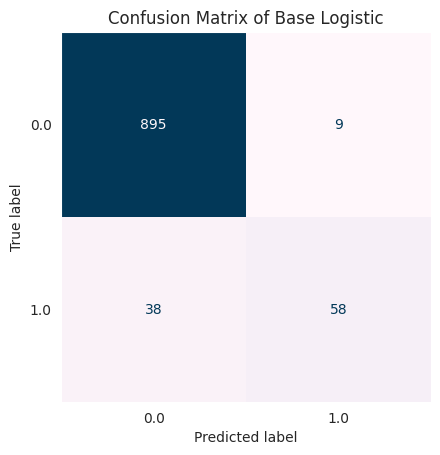

In [145]:
#ConfusionMatrix
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test1, y_test1, colorbar=False, cmap='PuBu')
plt.title('Confusion Matrix of Base Logistic')
plt.grid(False)

In [146]:
print(classification_report(y_test1, y_pred))


              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       904
         1.0       0.87      0.60      0.71        96

    accuracy                           0.95      1000
   macro avg       0.91      0.80      0.84      1000
weighted avg       0.95      0.95      0.95      1000



In [148]:
#Calculate Performance Metrics
def metrics_calculator(y_test, y_pred, model_name):
    '''
    This function calculates all desired performance metrics for a given model.
    '''
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Precision','Recall','F1-score'],
                          columns = [model_name])
    return result

In [149]:
Baselog_result = metrics_calculator(y_test1, y_pred, 'Base Logistic')
Baselog_result

,Base Logistic
Accuracy,0.953000
Precision,0.912471
Recall,0.797105
F1-score,0.843036


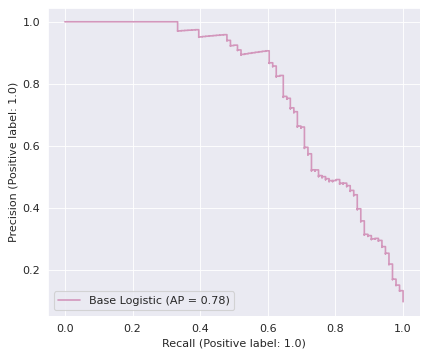

In [150]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=80)
PrecisionRecallDisplay.from_estimator(logistic_model, X_test1, y_test1, ax=ax, name='Base Logistic', color='#d397bc')
plt.show()

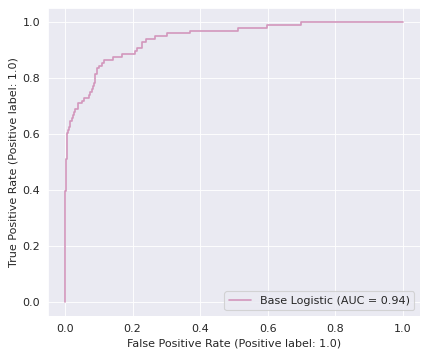

In [151]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=80)
RocCurveDisplay.from_estimator(logistic_model, X_test1, y_test1, ax=ax, name='Base Logistic', color='#d397bc')
plt.show()

In [153]:
from sklearn.model_selection import GridSearchCV

# Finding optimal hyperparameters(GridSearchCV)

# Define model
model = LogisticRegression()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

# Define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['max_iter'] = [100, 500, 1000]
space['multi_class'] = ['auto', 'ovr', 'multinomial']

# Define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# Execute search
GridSearchCV = search.fit(X_train1, y_train1)

# Set the clf to the best combination of parameters
logistic_modelcv = GridSearchCV.best_estimator_

# Summarize result
print('Best Score: %s' % GridSearchCV.best_score_)
print('Best Hyperparameters: %s' % GridSearchCV.best_params_)

Best Score: 0.9433172514619882
Best Hyperparameters: {'C': 100, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}


In [154]:
logistic_modelcv.fit(X_train1, y_train1)

LogisticRegression(C=100, max_iter=500, multi_class='multinomial')

In [155]:
y_pred = logistic_modelcv.predict(X_test1)

In [156]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test1, y_pred)))

Model accuracy score: 0.9520


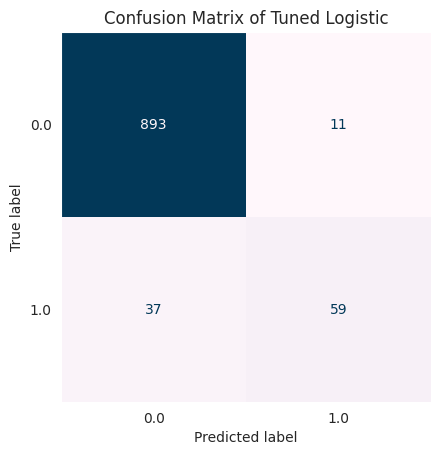

In [157]:
ConfusionMatrixDisplay.from_estimator(logistic_modelcv, X_test1, y_test1, colorbar=False, cmap='PuBu')
plt.title('Confusion Matrix of Tuned Logistic')
plt.grid(False)

In [158]:
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       904
         1.0       0.84      0.61      0.71        96

    accuracy                           0.95      1000
   macro avg       0.90      0.80      0.84      1000
weighted avg       0.95      0.95      0.95      1000



In [159]:
Finallog_result = metrics_calculator(y_test1, y_pred, 'Tuned Logistic')
Finallog_result

,Tuned Logistic
Accuracy,0.952000
Precision,0.901536
Recall,0.801208
F1-score,0.842336


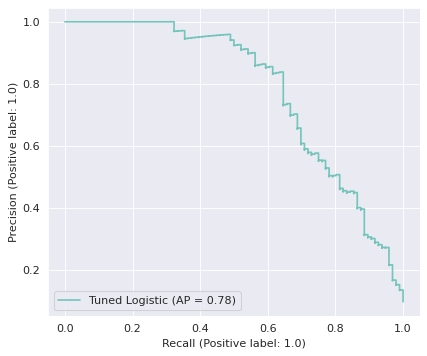

In [160]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=80)
PrecisionRecallDisplay.from_estimator(logistic_modelcv, X_test1, y_test1, ax=ax, name='Tuned Logistic', color='#73c4ba')
plt.show()

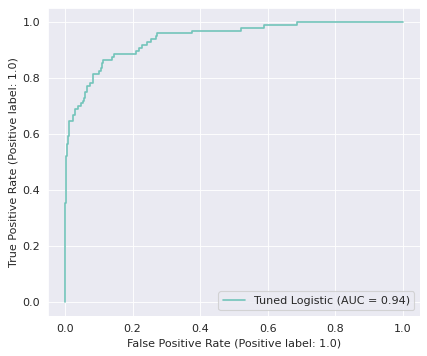

In [161]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=80)
RocCurveDisplay.from_estimator(logistic_modelcv, X_test1, y_test1, ax=ax, name='Tuned Logistic', color='#73c4ba')
plt.show()

**Predecting new sample**

In [189]:

df1 = df.copy()
df2 = pd.DataFrame ({"Age" : [42], "Experience" : [16], "Income" : [2.5], "Family" : [3],
                    "CCAvg" : [1.2], "Education" : [3], "Mortgage" : [0],"Personal Loan" : [1],
                    "Securities Account" : [1], "CD Account" : [0], "Online" : [1], "CreditCard" : [1]})

In [190]:
Df = pd.concat([df1, df2])
Df.reset_index(drop=True, inplace=True)
Df.tail()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
4996,30,4,1.25,4,0.4,1,85,0,0,0,1.0,0
4997,63,39,2.00,2,0.3,3,0,0,0,0,0.0,0
4998,65,40,4.08,3,0.5,2,0,0,0,0,1.0,0
4999,28,4,6.92,3,0.8,1,0,0,0,0,1.0,1
5000,42,16,2.50,3,1.2,3,0,1,1,0,1.0,1


In [191]:
X_train_sample1 = Df [["Age", "Experience", "Income", "Family", "CCAvg", "Education", "Mortgage",
                      "Securities Account", "CD Account", "Online", "CreditCard"]][:5000]
y_train_sample1 = Df ["Personal Loan"][:5000].ravel()

In [192]:
X_test_sample1 = Df [["Age", "Experience", "Income", "Family", "CCAvg", "Education", "Mortgage",
                     "Securities Account", "CD Account", "Online", "CreditCard"]][5000:]
X_test_sample1



,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
5000,42,16,2.5,3,1.2,3,0,1,0,1.0,1


In [239]:


# If it's not an integer type, handle non-numeric values
if y_train_sample1.dtype != 'int':
    # Replace empty strings or spaces with a suitable default value (e.g., -1)
    y_train_sample1 = np.where(y_train_sample1 == ' ', -1, y_train_sample1)
    y_train_sample1 = y_train_sample1.astype(int)

# Re-fit the model
logreg_sample.fit(X_train_sample1, y_train_sample1)

LogisticRegression(C=1, multi_class='multinomial', solver='newton-cg')

In [240]:
y_pred_sample1 = logreg_sample.predict (X_test_sample1)
print ("Personal Loan Result:", y_pred_sample1)

Personal Loan Result: [0]
